In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

import flwr as fl
import matplotlib.pyplot as plt
import numpy as np 
from typing import List, Tuple
from flwr.common import Metrics
import ray
#https://medium.com/mlearning-ai/evaluating-federated-learning-from-felt-labs-on-mnist-dataset-cbe081b28786
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth
enable_tf_gpu_growth()


2024-02-13 05:58:27.382252: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-13 05:58:27.411020: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 05:58:27.411053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 05:58:27.412446: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 05:58:27.417560: I tensorflow/core/platform/cpu_feature_guar

# Data Processing

In [2]:
def getMnistData():
    (traindataset,testDataset),datasetinfo = tfds.load(
        'mnist',
        split=['train','test'],
        shuffle_files= True,
        as_supervised= True,
        with_info= True
    )
    return traindataset,testDataset,datasetinfo

In [3]:
def dataset_to_numpy(dataset):
    features = []
    labels = []
    for image, label in tfds.as_numpy(dataset):
        features.append(image)
        labels.append(label)
    return np.array(features), np.array(labels)

def Splitset(intrain,intest):
    Train_images, Train_label = dataset_to_numpy(intrain)
    Test_images, Test_label = dataset_to_numpy(intest)
    return  Train_images, Train_label,Test_images, Test_label

def datanorm(data):
    return data/255 

In [4]:
trainset,testset, info = getMnistData()
Train_images, Train_label,Test_images, Test_label = Splitset(trainset,testset)
Train_images_n = datanorm(Train_images)
Test_images_n = datanorm(Test_images)


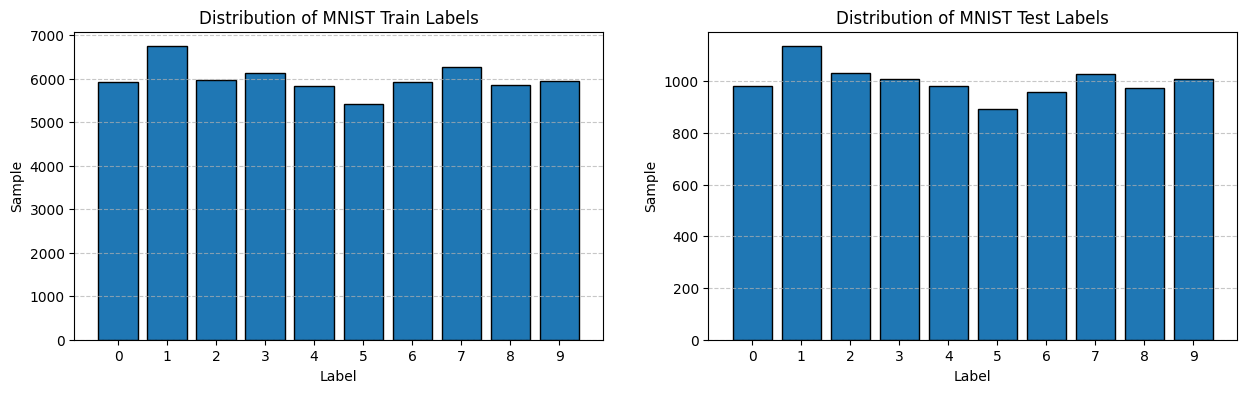

In [5]:
fig_1,axs_1 = plt.subplots(1,2,figsize = (15,4))
axs_1[0].hist(Train_label, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black',label='Train')
axs_1[0].set_title('Distribution of MNIST Train Labels')
axs_1[0].set_xlabel('Label')
axs_1[0].set_ylabel('Sample')
axs_1[0].set_xticks(range(10))  # Digits 0 to 9
axs_1[0].grid(axis='y', linestyle='--', alpha=0.7)

axs_1[1].hist(Test_label, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black',label='Train')
axs_1[1].set_title('Distribution of MNIST Test Labels')
axs_1[1].set_xlabel('Label')
axs_1[1].set_ylabel('Sample')
axs_1[1].set_xticks(range(10))  # Digits 0 to 9
axs_1[1].grid(axis='y', linestyle='--', alpha=0.7)


# Partition DataSet

In [6]:
def split_into_partition(data, labels, num_partitions):
    # Combine data and labels
    combined_data = list(zip(data, labels))
    np.random.shuffle(combined_data)  # Shuffle the combined data randomly

    partitions = [[] for _ in range(num_partitions)]
    store_label = np.unique(labels).tolist()
    counter = 0
    count = 0
    # Iterate over unique labels to efficiently distribute them across partitions
    while store_label:
        random_choice = np.random.choice(store_label)

        # Extract data and labels for the selected class
        class_data = [item[0] for item in combined_data if item[1] == random_choice]
        class_labels = [random_choice] * len(class_data)

        # Distribute the class data evenly among partitions
        modnum = len(np.unique(labels)) // num_partitions

        if counter == (num_partitions - 1):
            partitions[counter].extend(list(zip(class_data, class_labels)))
        elif count <= modnum:
            # Extend the selected partition with the data and labels
            count+=1
            partitions[counter].extend(list(zip(class_data, class_labels)))
            if count == modnum:
                counter += 1
                count=0


        store_label.remove(random_choice)

   # Separate data and labels after partitioning
    data_partitions = [np.array(list(zip(*partition))[0]) if partition else np.array([]) for partition in partitions]
    label_partitions = [np.array(list(zip(*partition))[1]) if partition else np.array([]) for partition in partitions]


    return data_partitions, label_partitions

In [7]:
NumOfPartition = 2
train_image_part,train_label_part = split_into_partition(Train_images_n,Train_label,NumOfPartition)

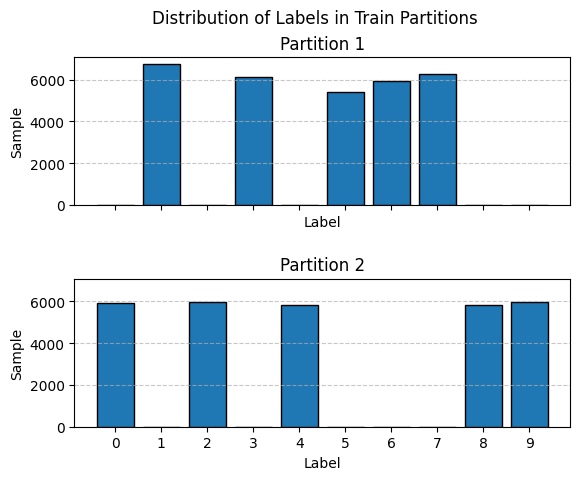

In [8]:
# Plot histogram for each partition
fig, axs = plt.subplots(NumOfPartition, sharex=True, sharey=True)

for i, partition in enumerate(train_label_part):
    axs[i].hist(partition, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black')
    axs[i].set_title(f'Partition {i + 1}')
    axs[i].set_xlabel('Label')
    axs[i].set_ylabel('Sample')
    axs[i].set_xticks(range(10))
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Distribution of Labels in Train Partitions')
plt.show()

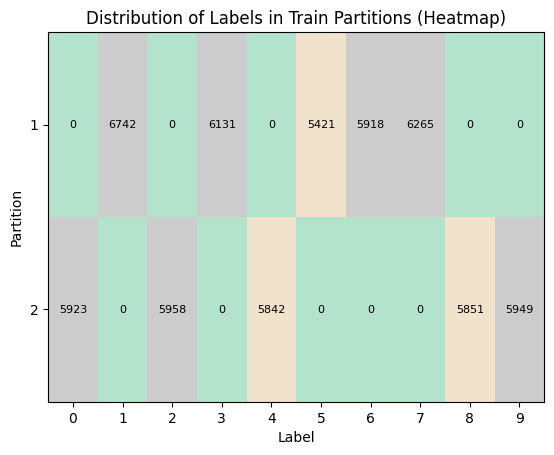

In [9]:
# Create an array to store the histogram data for each partition
hist_data = [np.histogram(partition, bins=range(11))[0] for partition in train_label_part]

# Plot heatmap
fig, ax = plt.subplots()
im = ax.imshow(hist_data, cmap='Pastel2',aspect='auto', interpolation='none')

# Add annotations
for i in range(len(train_label_part)):
    for j in range(10):
        text = ax.text(j, i, hist_data[i][j], ha='center', va='center', color='black', fontsize=8)

# Set labels and ticks
ax.set_title('Distribution of Labels in Train Partitions (Heatmap)')
ax.set_xlabel('Label')
ax.set_ylabel('Partition')
ax.set_xticks(range(10))
ax.set_yticks(range(len(train_label_part)))
ax.set_xticklabels(range(10))
ax.set_yticklabels(range(1, len(train_label_part) + 1))

# Add colorbar
plt.colorbar(im, ax=ax).remove()

plt.show()

In [10]:
def customCNNModel():
    model = keras.Sequential()
    # First convolutional layer
    model.add(keras.layers.Conv2D(20, (3, 3), activation='relu', input_shape=(28,28,1)))
    model.add(keras.layers.MaxPooling2D(pool_size=(3, 3),strides=(2,2)))
    # Flatten the output before the fully connected layers
    model.add(keras.layers.Flatten())
    # Fully connected layers
    model.add(keras.layers.Dense(100, activation='relu'))       
    # Output layer
    model.add(keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss= "sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# Client

In [11]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, train_x,train_y,val_x,val_y, model) -> None:
        super().__init__()
        self.train_feature_set = train_x
        self.train_label_set = train_y
        self.val_feature_set = val_x
        self.val_label_set = val_y
        self.model = model
        
    def get_parameters(self, config):
        return self.model.get_weights()
    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        print(f"round :{config['current_round']}")
        print(f"Train :{len(self.train_feature_set)}")
        print(f"Test :{len(self.val_feature_set)}")

        # Train the returned model
        TrainHistory = self.model.fit(x=self.train_feature_set, 
                                 y=self.train_label_set,
                                 verbose=2, 
                                 batch_size=config['batch_size'],
                                 epochs=config['local_epochs'],
                                 validation_data =(self.val_feature_set,self.val_label_set)
                                 )
        result ={
                "loss": TrainHistory.history['loss'][-1],
                "accuracy": round(TrainHistory.history['accuracy'][-1]*100,2),
                "val_loss" : TrainHistory.history['val_loss'][-1],
                "val_accuracy"  : round(TrainHistory.history["val_accuracy"][-1]*100,2),
        }

        print("Client Train and validate Done!!!")       
        # Send local model to server to do aggreation
        return self.model.get_weights(), len(self.train_feature_set),result

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        # Test Global model
        loss, accuracy = self.model.evaluate(self.val_feature_set,
                                        self.val_label_set,
                                        batch_size=config['batch_size'],
                                        verbose=2)
        print("Global Validate Done!!!")       
        return loss, len(self.val_feature_set), {"accuracy": round(float(accuracy*100),2)}


def generate_client_fn(train_x,train_y,val_x,val_y, model):
    """Return a function to construct a FlowerClient."""

    def client_fn(cid: str):
        print
        return FlowerClient(train_x[int(cid)],train_y[int(cid)],val_x,val_y,model)
    return client_fn


# Server

In [12]:
# config for Client using Server side
def fit_config(server_round: int):
    """Return training configuration dict for each round."""
    config = {
        "batch_size": 32,
        "current_round": server_round,
        "local_epochs": 50,
    }
    return config

def evalute_config(server_round: int):
    """Return test configuration dict for each round."""
    config = {
        "batch_size": 1,
        "current_round": server_round,
    }
    return config

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

def fit_average(metric):
    examples = [num_examples for num_examples, _ in metric]
    trainacc = [num_examples * m["accuracy"] for num_examples, m in metric]
    valacc = [num_examples * m["val_accuracy"] for num_examples, m in metric]
    
    return { "example": sum(examples),
            "accuracy": sum(trainacc) / sum(examples),
            "valacc": sum(valacc) / sum(examples)
            }





In [13]:
Fedavgconfig = fl.server.strategy.FedAvg(on_fit_config_fn=fit_config,
                                         on_evaluate_config_fn=evalute_config,
                                         evaluate_metrics_aggregation_fn=weighted_average,
                                         fit_metrics_aggregation_fn=fit_average,
                                         min_evaluate_clients= NumOfPartition,
                                         min_fit_clients=NumOfPartition,
                                         min_available_clients=NumOfPartition,
                                        )

# Simulation

In [14]:
globalmodel = customCNNModel()
clientfn = generate_client_fn(train_image_part,train_label_part,Test_images_n,Test_label,globalmodel)


In [15]:
history = fl.simulation.start_simulation(
        client_fn=clientfn,
        num_clients=NumOfPartition,
        config=fl.server.ServerConfig(num_rounds=10),
        strategy=Fedavgconfig,
        ray_init_args ={
            "include_dashboard": True, # we need this one for tracking,
        },
        actor_kwargs={
        "on_actor_init_fn": enable_tf_gpu_growth # <-- To be executed upon actor init.
    },
        client_resources = {'num_cpus': 8, 'num_gpus': 1}, # A Python dict specifying CPU/GPU resources
    )

INFO flwr 2024-02-13 05:58:36,584 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2024-02-13 05:58:38,205	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2024-02-13 05:58:38,949 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 16.0, 'node:10.91.229.129': 1.0, 'object_store_memory': 3530901504.0, 'memory': 7061803008.0, 'accelerator_type:G': 1.0, 'GPU': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 16.0, 'node:10.91.229.129': 1.0, 'object_store_memory': 3530901504.0, 'memory': 7061803008.0, 'accelerator_type:G': 1.0, 'GPU': 1.0}
INFO flwr 2024-02-13 05:58:38,950 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Opti

(DefaultActor pid=291482) round :1
(DefaultActor pid=291482) Train :30477
(DefaultActor pid=291482) Test :10000
(DefaultActor pid=291482) Epoch 1/50
(DefaultActor pid=291482) 953/953 - 3s - loss: 0.0964 - accuracy: 0.9697 - val_loss: 5.2208 - val_accuracy: 0.4964 - 3s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 2/50
(DefaultActor pid=291482) 953/953 - 3s - loss: 0.0269 - accuracy: 0.9919 - val_loss: 5.8548 - val_accuracy: 0.4984 - 3s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 3/50
(DefaultActor pid=291482) 953/953 - 3s - loss: 0.0180 - accuracy: 0.9945 - val_loss: 5.9753 - val_accuracy: 0.4992 - 3s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 4/50
(DefaultActor pid=291482) 953/953 - 3s - loss: 0.0133 - accuracy: 0.9953 - val_loss: 5.7065 - val_accuracy: 0.4992 - 3s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 5/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 0.0099 - accuracy: 0.9968 - val_loss: 6.1921 - val_accuracy: 0.4992 - 2s/epoch - 2ms/step
(DefaultActor pid=

(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) Epoch 1/50
(DefaultActor pid=291482) 923/923 - 3s - loss: 0.1285 - accuracy: 0.9604 - val_loss: 5.8825 - val_accuracy: 0.4890 - 3s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 2/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 0.0436 - accuracy: 0.9863 - val_loss: 5.5159 - val_accuracy: 0.4900 - 2s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 3/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 0.0317 - accuracy: 0.9900 - val_loss: 6.2321 - val_accuracy: 0.4914 - 2s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 4/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 0.0235 - accuracy: 0.9925 - val_loss: 6.7300 - val_accuracy: 0.4924 - 2s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 5/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 0.0171 - accuracy: 0.9948 - val_loss: 7.7101 - val_accuracy: 0.4880 - 2s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 6/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 0.0138 - accuracy: 0.9954 - val_loss: 7.1822 -

DEBUG flwr 2024-02-13 06:02:51,320 | server.py:236 | fit_round 1 received 2 results and 0 failures
DEBUG:flwr:fit_round 1 received 2 results and 0 failures
DEBUG flwr 2024-02-13 06:02:51,323 | server.py:173 | evaluate_round 1: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 1: strategy sampled 2 clients (out of 2)
(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) 923/923 - 2s - loss: 1.0442e-08 - accuracy: 1.0000 - val_loss: 24.8091 - val_accuracy: 0.4938 - 2s/epoch - 3ms/step
(DefaultActor pid=291482) Client Train and validate Done!!!


(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) 10000/10000 - 6s - loss: 0.3998 - accuracy: 0.8896 - 6s/epoch - 601us/step
(DefaultActor pid=291482) Global Validate Done!!!


DEBUG flwr 2024-02-13 06:03:03,672 | server.py:187 | evaluate_round 1 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 2 results and 0 failures
DEBUG flwr 2024-02-13 06:03:03,673 | server.py:222 | fit_round 2: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 2: strategy sampled 2 clients (out of 2)
(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) 10000/10000 - 6s - loss: 0.3998 - accuracy: 0.8896 - 6s/epoch - 604us/step
(DefaultActor pid=291482) Global Validate Done!!!
(DefaultActor pid=291482) round :2
(DefaultActor pid=291482) Train :29523
(DefaultActor pid=291482) Test :10000
(DefaultActor pid=291482) Epoch 1/50
(DefaultActor pid=291482) 923/923 - 3s - loss: 0.0108 - accuracy: 0.9963 - val_loss: 2.9255 - val_accuracy: 0.5461 - 3s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 2/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 0.0030 - accuracy: 0.9990 - val_loss: 4.1021 - val_accuracy: 0.5094 - 2s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 3/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 0.0030 - accuracy: 0.9990 - val_loss: 4.7518 - val_accuracy: 0.5146 - 2s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 4/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 0.0023 - accuracy: 0.9992 - val_loss: 5.1059 - val_accuracy: 0.5064 - 2s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 5/50
(Def

(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) 923/923 - 3s - loss: 2.5781e-06 - accuracy: 1.0000 - val_loss: 12.3815 - val_accuracy: 0.4944 - 3s/epoch - 3ms/step
(DefaultActor pid=291482) Client Train and validate Done!!!
(DefaultActor pid=291482) round :2
(DefaultActor pid=291482) Train :30477
(DefaultActor pid=291482) Test :10000
(DefaultActor pid=291482) Epoch 1/50
(DefaultActor pid=291482) 953/953 - 3s - loss: 0.0050 - accuracy: 0.9982 - val_loss: 5.0439 - val_accuracy: 0.5055 - 3s/epoch - 4ms/step
(DefaultActor pid=291482) Epoch 2/50
(DefaultActor pid=291482) 953/953 - 3s - loss: 0.0026 - accuracy: 0.9992 - val_loss: 5.1625 - val_accuracy: 0.5020 - 3s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 3/50
(DefaultActor pid=291482) 953/953 - 3s - loss: 7.9392e-04 - accuracy: 0.9998 - val_loss: 6.0121 - val_accuracy: 0.5010 - 3s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 4/50
(DefaultActor pid=291482) 953/953 - 3s - loss: 0.0031 - accuracy: 0.9988 - val_loss: 6.8833 - val_accuracy: 0.5000 - 3s/epo

DEBUG flwr 2024-02-13 06:07:35,391 | server.py:236 | fit_round 2 received 2 results and 0 failures
DEBUG:flwr:fit_round 2 received 2 results and 0 failures
DEBUG flwr 2024-02-13 06:07:35,395 | server.py:173 | evaluate_round 2: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 2: strategy sampled 2 clients (out of 2)
(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) 953/953 - 3s - loss: 8.0185e-10 - accuracy: 1.0000 - val_loss: 19.7435 - val_accuracy: 0.4998 - 3s/epoch - 3ms/step
(DefaultActor pid=291482) Client Train and validate Done!!!
(DefaultActor pid=291482) 10000/10000 - 6s - loss: 0.2802 - accuracy: 0.9399 - 6s/epoch - 622us/step
(DefaultActor pid=291482) Global Validate Done!!!


(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 06:07:48,154 | server.py:187 | evaluate_round 2 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2024-02-13 06:07:48,155 | server.py:222 | fit_round 3: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 3: strategy sampled 2 clients (out of 2)
(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) 10000/10000 - 6s - loss: 0.2802 - accuracy: 0.9399 - 6s/epoch - 622us/step
(DefaultActor pid=291482) Global Validate Done!!!
(DefaultActor pid=291482) round :3
(DefaultActor pid=291482) Train :29523
(DefaultActor pid=291482) Test :10000
(DefaultActor pid=291482) Epoch 1/50
(DefaultActor pid=291482) 923/923 - 3s - loss: 0.0048 - accuracy: 0.9984 - val_loss: 3.0116 - val_accuracy: 0.5985 - 3s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 2/50
(DefaultActor pid=291482) 923/923 - 3s - loss: 0.0020 - accuracy: 0.9993 - val_loss: 3.4826 - val_accuracy: 0.5934 - 3s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 3/50
(DefaultActor pid=291482) 923/923 - 3s - loss: 4.3809e-04 - accuracy: 0.9999 - val_loss: 4.2828 - val_accuracy: 0.5614 - 3s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 4/50
(DefaultActor pid=291482) 923/923 - 3s - loss: 5.5000e-05 - accuracy: 1.0000 - val_loss: 4.5374 - val_accuracy: 0.5548 - 3s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 5

(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) Epoch 1/50
(DefaultActor pid=291482) 953/953 - 3s - loss: 0.0014 - accuracy: 0.9995 - val_loss: 4.4502 - val_accuracy: 0.5489 - 3s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 2/50
(DefaultActor pid=291482) 953/953 - 3s - loss: 6.2063e-04 - accuracy: 0.9999 - val_loss: 4.8631 - val_accuracy: 0.5459 - 3s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 3/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 2.8669e-05 - accuracy: 1.0000 - val_loss: 5.0549 - val_accuracy: 0.5406 - 2s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 4/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 5.3247e-06 - accuracy: 1.0000 - val_loss: 5.2452 - val_accuracy: 0.5393 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 5/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 3.3950e-06 - accuracy: 1.0000 - val_loss: 5.4224 - val_accuracy: 0.5384 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 6/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 2.3632e-06 - accuracy: 1.0000 

DEBUG flwr 2024-02-13 06:11:40,105 | server.py:236 | fit_round 3 received 2 results and 0 failures
DEBUG:flwr:fit_round 3 received 2 results and 0 failures
DEBUG flwr 2024-02-13 06:11:40,108 | server.py:173 | evaluate_round 3: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 3: strategy sampled 2 clients (out of 2)
(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) 953/953 - 2s - loss: 1.9557e-10 - accuracy: 1.0000 - val_loss: 16.3449 - val_accuracy: 0.5028 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Client Train and validate Done!!!


(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) 10000/10000 - 6s - loss: 0.3140 - accuracy: 0.9540 - 6s/epoch - 553us/step
(DefaultActor pid=291482) Global Validate Done!!!


DEBUG flwr 2024-02-13 06:11:51,640 | server.py:187 | evaluate_round 3 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2024-02-13 06:11:51,640 | server.py:222 | fit_round 4: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 4: strategy sampled 2 clients (out of 2)
(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) 10000/10000 - 6s - loss: 0.3140 - accuracy: 0.9540 - 6s/epoch - 574us/step
(DefaultActor pid=291482) Global Validate Done!!!
(DefaultActor pid=291482) round :4
(DefaultActor pid=291482) Train :29523
(DefaultActor pid=291482) Test :10000
(DefaultActor pid=291482) Epoch 1/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 0.0037 - accuracy: 0.9990 - val_loss: 4.1913 - val_accuracy: 0.6408 - 2s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 2/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 7.9871e-04 - accuracy: 0.9997 - val_loss: 3.0300 - val_accuracy: 0.6852 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 3/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 0.0046 - accuracy: 0.9987 - val_loss: 3.9436 - val_accuracy: 0.5931 - 2s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 4/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 5.6003e-04 - accuracy: 0.9998 - val_loss: 5.0537 - val_accuracy: 0.5700 - 2s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 5

(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) Epoch 1/50
(DefaultActor pid=291482) 953/953 - 3s - loss: 0.0022 - accuracy: 0.9992 - val_loss: 5.6148 - val_accuracy: 0.5750 - 3s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 2/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 0.0015 - accuracy: 0.9996 - val_loss: 5.5672 - val_accuracy: 0.5804 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 3/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 8.3387e-04 - accuracy: 0.9999 - val_loss: 4.7016 - val_accuracy: 0.6004 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 4/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 3.5728e-05 - accuracy: 1.0000 - val_loss: 5.2581 - val_accuracy: 0.5842 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 5/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 0.0017 - accuracy: 0.9996 - val_loss: 6.0042 - val_accuracy: 0.5465 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 6/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 0.0029 - accuracy: 0.9991 - val_loss: 

DEBUG flwr 2024-02-13 06:15:27,045 | server.py:236 | fit_round 4 received 2 results and 0 failures
DEBUG:flwr:fit_round 4 received 2 results and 0 failures
DEBUG flwr 2024-02-13 06:15:27,047 | server.py:173 | evaluate_round 4: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 4: strategy sampled 2 clients (out of 2)
(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) 953/953 - 2s - loss: 1.0561e-10 - accuracy: 1.0000 - val_loss: 13.4686 - val_accuracy: 0.5137 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Client Train and validate Done!!!
(DefaultActor pid=291482) 10000/10000 - 6s - loss: 0.5512 - accuracy: 0.9349 - 6s/epoch - 552us/step
(DefaultActor pid=291482) Global Validate Done!!!


(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 06:15:38,425 | server.py:187 | evaluate_round 4 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2024-02-13 06:15:38,425 | server.py:222 | fit_round 5: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 5: strategy sampled 2 clients (out of 2)
(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) 10000/10000 - 6s - loss: 0.5512 - accuracy: 0.9349 - 6s/epoch - 560us/step
(DefaultActor pid=291482) Global Validate Done!!!
(DefaultActor pid=291482) round :5
(DefaultActor pid=291482) Train :29523
(DefaultActor pid=291482) Test :10000
(DefaultActor pid=291482) Epoch 1/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 0.0072 - accuracy: 0.9986 - val_loss: 5.9575 - val_accuracy: 0.6300 - 2s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 2/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 0.0013 - accuracy: 0.9997 - val_loss: 4.6780 - val_accuracy: 0.6627 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 3/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 3.0623e-05 - accuracy: 1.0000 - val_loss: 4.2106 - val_accuracy: 0.6783 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 4/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 3.2122e-05 - accuracy: 1.0000 - val_loss: 4.4854 - val_accuracy: 0.6624 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 5

(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) 923/923 - 2s - loss: 1.6555e-10 - accuracy: 1.0000 - val_loss: 5.9430 - val_accuracy: 0.6658 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Client Train and validate Done!!!
(DefaultActor pid=291482) round :5
(DefaultActor pid=291482) Train :30477
(DefaultActor pid=291482) Test :10000
(DefaultActor pid=291482) Epoch 1/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 0.0012 - accuracy: 0.9997 - val_loss: 5.5773 - val_accuracy: 0.6462 - 2s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 2/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 1.2176e-06 - accuracy: 1.0000 - val_loss: 5.5869 - val_accuracy: 0.6464 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 3/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 1.2174e-07 - accuracy: 1.0000 - val_loss: 5.6429 - val_accuracy: 0.6451 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 4/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 7.6872e-08 - accuracy: 1.0000 - val_loss: 5.6800 - val_accuracy: 0.6437 -

DEBUG flwr 2024-02-13 06:19:16,427 | server.py:236 | fit_round 5 received 2 results and 0 failures
DEBUG:flwr:fit_round 5 received 2 results and 0 failures
DEBUG flwr 2024-02-13 06:19:16,429 | server.py:173 | evaluate_round 5: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 5: strategy sampled 2 clients (out of 2)
(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) 953/953 - 2s - loss: 1.2125e-10 - accuracy: 1.0000 - val_loss: 9.1239 - val_accuracy: 0.6029 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Client Train and validate Done!!!
(DefaultActor pid=291482) 10000/10000 - 6s - loss: 0.3794 - accuracy: 0.9591 - 6s/epoch - 562us/step
(DefaultActor pid=291482) Global Validate Done!!!


(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 06:19:27,851 | server.py:187 | evaluate_round 5 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2024-02-13 06:19:27,852 | server.py:222 | fit_round 6: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 6: strategy sampled 2 clients (out of 2)
(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) 10000/10000 - 6s - loss: 0.3794 - accuracy: 0.9591 - 6s/epoch - 554us/step
(DefaultActor pid=291482) Global Validate Done!!!
(DefaultActor pid=291482) round :6
(DefaultActor pid=291482) Train :30477
(DefaultActor pid=291482) Test :10000
(DefaultActor pid=291482) Epoch 1/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 0.0027 - accuracy: 0.9996 - val_loss: 6.1123 - val_accuracy: 0.6508 - 2s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 2/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 1.1536e-07 - accuracy: 1.0000 - val_loss: 6.1936 - val_accuracy: 0.6475 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 3/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 5.1351e-08 - accuracy: 1.0000 - val_loss: 6.2539 - val_accuracy: 0.6452 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 4/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 3.6880e-08 - accuracy: 1.0000 - val_loss: 6.3061 - val_accuracy: 0.6442 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epo

(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) 953/953 - 2s - loss: 8.9963e-11 - accuracy: 1.0000 - val_loss: 8.9360 - val_accuracy: 0.6191 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Client Train and validate Done!!!
(DefaultActor pid=291482) round :6
(DefaultActor pid=291482) Train :29523
(DefaultActor pid=291482) Test :10000
(DefaultActor pid=291482) Epoch 1/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 0.0033 - accuracy: 0.9993 - val_loss: 3.4129 - val_accuracy: 0.7260 - 2s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 2/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 0.0045 - accuracy: 0.9991 - val_loss: 4.2072 - val_accuracy: 0.6853 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 3/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 0.0012 - accuracy: 0.9997 - val_loss: 4.8213 - val_accuracy: 0.6522 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 4/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 1.5385e-05 - accuracy: 1.0000 - val_loss: 4.8706 - val_accuracy: 0.6519 - 2s/epoc

DEBUG flwr 2024-02-13 06:23:05,915 | server.py:236 | fit_round 6 received 2 results and 0 failures
DEBUG:flwr:fit_round 6 received 2 results and 0 failures
DEBUG flwr 2024-02-13 06:23:05,918 | server.py:173 | evaluate_round 6: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 6: strategy sampled 2 clients (out of 2)
(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) 923/923 - 2s - loss: 3.5569e-08 - accuracy: 1.0000 - val_loss: 10.3931 - val_accuracy: 0.5149 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Client Train and validate Done!!!
(DefaultActor pid=291482) 10000/10000 - 6s - loss: 0.7525 - accuracy: 0.9164 - 6s/epoch - 559us/step
(DefaultActor pid=291482) Global Validate Done!!!


(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 06:23:17,288 | server.py:187 | evaluate_round 6 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2024-02-13 06:23:17,289 | server.py:222 | fit_round 7: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 7: strategy sampled 2 clients (out of 2)
(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) 10000/10000 - 6s - loss: 0.7525 - accuracy: 0.9164 - 6s/epoch - 550us/step
(DefaultActor pid=291482) Global Validate Done!!!
(DefaultActor pid=291482) round :7
(DefaultActor pid=291482) Train :30477
(DefaultActor pid=291482) Test :10000
(DefaultActor pid=291482) Epoch 1/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 0.0073 - accuracy: 0.9989 - val_loss: 4.6120 - val_accuracy: 0.6710 - 2s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 2/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 1.5414e-05 - accuracy: 1.0000 - val_loss: 4.6033 - val_accuracy: 0.6716 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 3/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 9.8110e-07 - accuracy: 1.0000 - val_loss: 4.6272 - val_accuracy: 0.6708 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 4/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 2.2720e-07 - accuracy: 1.0000 - val_loss: 4.6473 - val_accuracy: 0.6702 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epo

(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) 953/953 - 2s - loss: 8.6052e-11 - accuracy: 1.0000 - val_loss: 9.0282 - val_accuracy: 0.6283 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Client Train and validate Done!!!
(DefaultActor pid=291482) round :7
(DefaultActor pid=291482) Train :29523
(DefaultActor pid=291482) Test :10000
(DefaultActor pid=291482) Epoch 1/50
(DefaultActor pid=291482) 923/923 - 3s - loss: 0.0037 - accuracy: 0.9994 - val_loss: 5.6602 - val_accuracy: 0.6368 - 3s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 2/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 0.0036 - accuracy: 0.9991 - val_loss: 9.3095 - val_accuracy: 0.5263 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 3/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 9.4958e-04 - accuracy: 0.9998 - val_loss: 7.6581 - val_accuracy: 0.5485 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 4/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 3.3328e-06 - accuracy: 1.0000 - val_loss: 7.6305 - val_accuracy: 0.5487 - 2s/

DEBUG flwr 2024-02-13 06:26:52,647 | server.py:236 | fit_round 7 received 2 results and 0 failures
DEBUG:flwr:fit_round 7 received 2 results and 0 failures
DEBUG flwr 2024-02-13 06:26:52,650 | server.py:173 | evaluate_round 7: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 7: strategy sampled 2 clients (out of 2)
(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) 923/923 - 2s - loss: 7.2681e-11 - accuracy: 1.0000 - val_loss: 10.7342 - val_accuracy: 0.5435 - 2s/epoch - 3ms/step
(DefaultActor pid=291482) Client Train and validate Done!!!
(DefaultActor pid=291482) 10000/10000 - 6s - loss: 0.5125 - accuracy: 0.9507 - 6s/epoch - 571us/step
(DefaultActor pid=291482) Global Validate Done!!!


(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 06:27:04,108 | server.py:187 | evaluate_round 7 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2024-02-13 06:27:04,109 | server.py:222 | fit_round 8: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 8: strategy sampled 2 clients (out of 2)
(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) 10000/10000 - 5s - loss: 0.5125 - accuracy: 0.9507 - 5s/epoch - 546us/step
(DefaultActor pid=291482) Global Validate Done!!!
(DefaultActor pid=291482) round :8
(DefaultActor pid=291482) Train :30477
(DefaultActor pid=291482) Test :10000
(DefaultActor pid=291482) Epoch 1/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 0.0042 - accuracy: 0.9992 - val_loss: 4.7656 - val_accuracy: 0.7175 - 2s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 2/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 1.7617e-06 - accuracy: 1.0000 - val_loss: 5.3200 - val_accuracy: 0.6908 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 3/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 1.0853e-07 - accuracy: 1.0000 - val_loss: 5.3350 - val_accuracy: 0.6903 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 4/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 6.2833e-08 - accuracy: 1.0000 - val_loss: 5.3578 - val_accuracy: 0.6892 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epo

(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) Epoch 1/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 0.0056 - accuracy: 0.9993 - val_loss: 6.1904 - val_accuracy: 0.6491 - 2s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 2/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 0.0015 - accuracy: 0.9996 - val_loss: 5.2776 - val_accuracy: 0.6744 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 3/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 5.9465e-04 - accuracy: 0.9998 - val_loss: 6.0284 - val_accuracy: 0.6572 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 4/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 0.0020 - accuracy: 0.9997 - val_loss: 6.5763 - val_accuracy: 0.6300 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 5/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 3.3075e-04 - accuracy: 0.9999 - val_loss: 5.9518 - val_accuracy: 0.6438 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 6/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 0.0032 - accuracy: 0.9993 - val_loss: 

DEBUG flwr 2024-02-13 06:30:46,628 | server.py:236 | fit_round 8 received 2 results and 0 failures
DEBUG:flwr:fit_round 8 received 2 results and 0 failures
DEBUG flwr 2024-02-13 06:30:46,631 | server.py:173 | evaluate_round 8: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 8: strategy sampled 2 clients (out of 2)
(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) 923/923 - 2s - loss: 5.6530e-11 - accuracy: 1.0000 - val_loss: 12.6663 - val_accuracy: 0.5176 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Client Train and validate Done!!!
(DefaultActor pid=291482) 10000/10000 - 6s - loss: 0.8968 - accuracy: 0.9223 - 6s/epoch - 553us/step
(DefaultActor pid=291482) Global Validate Done!!!


(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 06:30:57,986 | server.py:187 | evaluate_round 8 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2024-02-13 06:30:57,987 | server.py:222 | fit_round 9: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 9: strategy sampled 2 clients (out of 2)
(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) 10000/10000 - 6s - loss: 0.8968 - accuracy: 0.9223 - 6s/epoch - 556us/step
(DefaultActor pid=291482) Global Validate Done!!!
(DefaultActor pid=291482) round :9
(DefaultActor pid=291482) Train :29523
(DefaultActor pid=291482) Test :10000
(DefaultActor pid=291482) Epoch 1/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 0.0016 - accuracy: 0.9997 - val_loss: 7.3412 - val_accuracy: 0.6243 - 2s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 2/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 0.0044 - accuracy: 0.9992 - val_loss: 7.9437 - val_accuracy: 0.5709 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 3/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 1.4494e-04 - accuracy: 0.9999 - val_loss: 8.8177 - val_accuracy: 0.5491 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 4/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 4.2407e-07 - accuracy: 1.0000 - val_loss: 8.8451 - val_accuracy: 0.5487 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 5

(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) Epoch 1/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 0.0106 - accuracy: 0.9985 - val_loss: 6.5542 - val_accuracy: 0.6744 - 2s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 2/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 9.0386e-07 - accuracy: 1.0000 - val_loss: 6.5900 - val_accuracy: 0.6728 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 3/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 1.3897e-07 - accuracy: 1.0000 - val_loss: 6.6141 - val_accuracy: 0.6718 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 4/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 1.0248e-07 - accuracy: 1.0000 - val_loss: 6.6276 - val_accuracy: 0.6718 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 5/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 8.1858e-08 - accuracy: 1.0000 - val_loss: 6.6453 - val_accuracy: 0.6706 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 6/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 6.3641e-08 - accuracy: 1.0000 

DEBUG flwr 2024-02-13 06:34:39,957 | server.py:236 | fit_round 9 received 2 results and 0 failures
DEBUG:flwr:fit_round 9 received 2 results and 0 failures
DEBUG flwr 2024-02-13 06:34:39,961 | server.py:173 | evaluate_round 9: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 9: strategy sampled 2 clients (out of 2)
(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) 953/953 - 2s - loss: 1.0170e-10 - accuracy: 1.0000 - val_loss: 10.2409 - val_accuracy: 0.6385 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Client Train and validate Done!!!
(DefaultActor pid=291482) 10000/10000 - 6s - loss: 0.6327 - accuracy: 0.9453 - 6s/epoch - 591us/step
(DefaultActor pid=291482) Global Validate Done!!!


(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 06:34:52,038 | server.py:187 | evaluate_round 9 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2024-02-13 06:34:52,039 | server.py:222 | fit_round 10: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 10: strategy sampled 2 clients (out of 2)
(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) 10000/10000 - 6s - loss: 0.6327 - accuracy: 0.9453 - 6s/epoch - 585us/step
(DefaultActor pid=291482) Global Validate Done!!!
(DefaultActor pid=291482) round :10
(DefaultActor pid=291482) Train :30477
(DefaultActor pid=291482) Test :10000
(DefaultActor pid=291482) Epoch 1/50
(DefaultActor pid=291482) 953/953 - 3s - loss: 0.0082 - accuracy: 0.9988 - val_loss: 8.2485 - val_accuracy: 0.6435 - 3s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 2/50
(DefaultActor pid=291482) 953/953 - 3s - loss: 0.0016 - accuracy: 0.9997 - val_loss: 7.3863 - val_accuracy: 0.6329 - 3s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 3/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 7.8178e-04 - accuracy: 0.9998 - val_loss: 6.0549 - val_accuracy: 0.6730 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 4/50
(DefaultActor pid=291482) 953/953 - 2s - loss: 0.0048 - accuracy: 0.9993 - val_loss: 5.6893 - val_accuracy: 0.6715 - 2s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 5/50

(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) Epoch 1/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 0.0027 - accuracy: 0.9995 - val_loss: 11.8232 - val_accuracy: 0.5841 - 2s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 2/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 0.0028 - accuracy: 0.9994 - val_loss: 10.5074 - val_accuracy: 0.5822 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 3/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 2.4752e-04 - accuracy: 0.9999 - val_loss: 9.3237 - val_accuracy: 0.6032 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 4/50
(DefaultActor pid=291482) 923/923 - 3s - loss: 0.0044 - accuracy: 0.9994 - val_loss: 10.2798 - val_accuracy: 0.5497 - 3s/epoch - 3ms/step
(DefaultActor pid=291482) Epoch 5/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 0.0027 - accuracy: 0.9994 - val_loss: 9.0559 - val_accuracy: 0.5559 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Epoch 6/50
(DefaultActor pid=291482) 923/923 - 2s - loss: 3.2074e-04 - accuracy: 0.9999 - val_los

DEBUG flwr 2024-02-13 06:38:37,202 | server.py:236 | fit_round 10 received 2 results and 0 failures
DEBUG:flwr:fit_round 10 received 2 results and 0 failures
DEBUG flwr 2024-02-13 06:38:37,204 | server.py:173 | evaluate_round 10: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 10: strategy sampled 2 clients (out of 2)
(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=291482) 923/923 - 2s - loss: 5.6530e-11 - accuracy: 1.0000 - val_loss: 13.3815 - val_accuracy: 0.5092 - 2s/epoch - 2ms/step
(DefaultActor pid=291482) Client Train and validate Done!!!
(DefaultActor pid=291482) 10000/10000 - 6s - loss: 0.5328 - accuracy: 0.9461 - 6s/epoch - 561us/step
(DefaultActor pid=291482) Global Validate Done!!!


(DefaultActor pid=291482) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 06:38:48,717 | server.py:187 | evaluate_round 10 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 2 results and 0 failures
INFO flwr 2024-02-13 06:38:48,718 | server.py:153 | FL finished in 2408.0261627170003
INFO:flwr:FL finished in 2408.0261627170003
INFO flwr 2024-02-13 06:38:48,719 | app.py:226 | app_fit: losses_distributed [(1, 0.39977338910102844), (2, 0.2802431583404541), (3, 0.3140101432800293), (4, 0.5512447357177734), (5, 0.37937039136886597), (6, 0.7524555921554565), (7, 0.5124886631965637), (8, 0.8967742323875427), (9, 0.6326593160629272), (10, 0.5327628254890442)]
INFO:flwr:app_fit: losses_distributed [(1, 0.39977338910102844), (2, 0.2802431583404541), (3, 0.3140101432800293), (4, 0.5512447357177734), (5, 0.37937039136886597), (6, 0.7524555921554565), (7, 0.5124886631965

In [16]:
Train_acc_result = [x[1] for x in history.metrics_distributed_fit['accuracy']]
Val_acc_result = [x[1] for x in history.metrics_distributed_fit['valacc']]
Test_acc_result = [x[1] for x in history.metrics_distributed['accuracy']]
iteration = [i for i in range(1,len(Train_acc_result)+1)]

(DefaultActor pid=291482) 10000/10000 - 6s - loss: 0.5328 - accuracy: 0.9461 - 6s/epoch - 565us/step
(DefaultActor pid=291482) Global Validate Done!!!


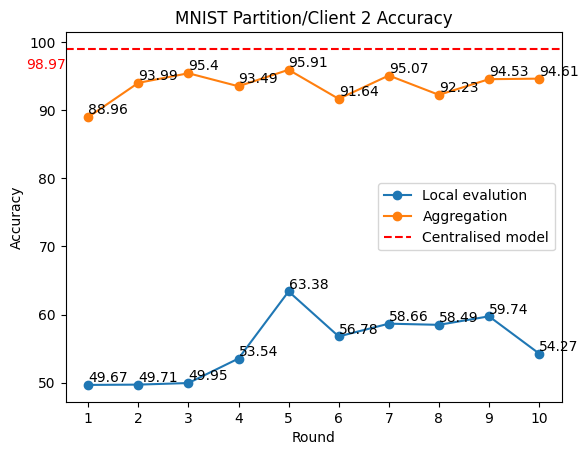

In [17]:
#plt.plot(iteration,Train_acc_result,marker='o',label="Train")
plt.title(f"MNIST Partition/Client {NumOfPartition} Accuracy")
plt.plot(iteration,Val_acc_result,marker='o',label="Local evalution")
plt.plot(iteration,Test_acc_result,marker='o',label="Aggregation")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.xticks(iteration)

for i, j in zip(iteration, Val_acc_result):
    plt.text(i, j,f"{round(j,2)}", ha='left', va='bottom')
for i, j in zip(iteration, Test_acc_result):
    plt.text(i, j,f"{round(j,2)}", ha='left', va='bottom')

average_value = 98.97
plt.gca().text(0, average_value/110, f"{average_value}", transform=plt.gca().transAxes, ha='right',color='r',)
plt.axhline(y=average_value, color='r', linestyle='--', label='Centralised model')

#plt.savefig(f"MNIST_Partition_Client_{NumOfPartition}_Accuracy.png")
plt.legend()
plt.show()